<a href="https://colab.research.google.com/github/Drew128/Task_2020_02_29/blob/master/Test_2020_02_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
%matplotlib inline

In [3]:
uploaded = files.upload()

Saving тест-статистика-dataset.tsv to тест-статистика-dataset.tsv


In [0]:
df = pd.read_csv(list(uploaded.keys())[0], delimiter='\t')

In [5]:
df.head()

,search_id,search_date,clicks,group
0,-3136706724385003188,2017-11-23,0,2
1,-3139609516900744687,2017-11-22,0,2
2,-776473245209166820,2017-11-22,0,2
3,2254608150971607405,2017-11-25,1,2
4,2397168305001145852,2017-11-24,0,2


In [11]:
df_once = df
df_once['click_at_least_once'] = (df_once['clicks'] > 0).astype(int)
agg = df_once.groupby('group').agg({'clicks':'mean', 'search_id':'count', 'click_at_least_once': 'sum'})
agg['CTR'] = agg['click_at_least_once']/agg['search_id']
agg

,clicks,search_id,click_at_least_once,CTR
group,,,,
2,0.557060,4802,1815,0.377968
3,0.512346,4860,1686,0.346914


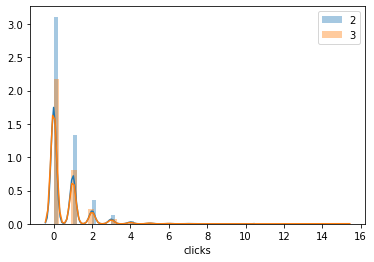

In [12]:
group_two = df[df.group == 2]['clicks']
group_three = df[df.group == 3]['clicks']
sns.distplot(group_two)
sns.distplot(group_three)
plt.legend(['2', '3'])

In [47]:
def ab_test(a, b, names=("a", "b")):
  name_a, name_b = names
  stat, p = mannwhitneyu(a, b)
  print('The null hypothesis: there is no difference in clicks cnt per search_id in groups')
  print(f'{name_a} group mean: {a.mean()}, \n{name_b} group mean: {b.mean()}, \nMann–Whitney U test:       P-value {p}')
  min_shape = min(a.shape[0], b.shape[0])
  stat, p = wilcoxon(a[:min_shape], b[:min_shape])
  print(f'Wilcoxon signed-rank test: P-value {p}')

ab_test(group_two, group_three, names=("2", "3"))

The null hypothesis: there is no difference in clicks cnt per search_id in groups
2 group mean: 0.5570595585172845, 
3 group mean: 0.5123456790123457, 
Mann–Whitney U test:       P-value 0.0009558193010902615
Wilcoxon signed-rank test: P-value 0.0040398171210834985


In [0]:
def get_bootstrap_samples(data, n_samples):
  indices = np.random.randint(0, len(data), size=(n_samples, len(data)))
  samples = np.array(data)[indices]
  return samples

def stat_intervals(stat, alpha):
  boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
  return boundaries

def statistic_func(samples):
  return np.array([np.mean(sample) for sample in samples])

def pipline(data, alpha=0.05, n_samples=5000):
  samples = get_bootstrap_samples(data, n_samples)
  statistic = statistic_func(samples)
  intervals = stat_intervals(statistic, alpha)
  return {"intervals":intervals, "statistic":statistic}

Group_2 intervals (95%):  [0.53102874 0.58350687]
Group_3 intervals (95%): [0.48744856 0.53786008]
Group_2 intervals (90%):  [0.53498542 0.57913369]
Group_3 intervals (90%): [0.49135802 0.53374486]


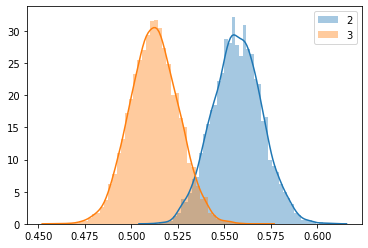

In [67]:
group_two_stat_95 = pipline(group_two, n_samples=10000, alpha=0.05)
group_three_stat_95 = pipline(group_three, n_samples=10000, alpha=0.05)

sns.distplot(group_two_stat_95['statistic'])
sns.distplot(group_three_stat_95['statistic'])
plt.legend(['2', '3'])
print('Group_2 intervals (95%): ', group_two_stat_95["intervals"])
print('Group_3 intervals (95%):', group_three_stat_95["intervals"])
print('Group_2 intervals (90%): ', stat_intervals(group_two_stat_95['statistic'], alpha=0.1))
print('Group_3 intervals (90%):', stat_intervals(group_three_stat_95['statistic'], alpha=0.1))

Difference intervals 95% Statistical significance:  [0.00941089 0.0814921 ]
Difference intervals 90% Statistical significance:  [0.01489536 0.07509997]
Group 2 performs about 8.66 % better
Group 2 had about 0.044 clicks more than group 3


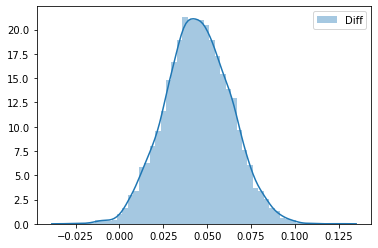

In [74]:
diff_95 = group_two_stat_95['statistic']-group_three_stat_95['statistic']
sns.distplot(diff_95)
plt.legend(['Diff'])
print('Difference intervals 95% Statistical significance: ', stat_intervals(diff, 0.05))
print('Difference intervals 90% Statistical significance: ', stat_intervals(diff, 0.1))
print(f"Group 2 performs about {round(diff.mean()/group_three_stat_95['statistic'].mean()*100, 2)} % better")
print(f"Group 2 had about {round(diff.mean(), 3)} clicks more than group 3")